# L3: Topic Models
### 732A92/TDDE16 Text Mining
Måns Magnusson

The purpose of this lab is to implement the standard Gibbs sampling algorithm for Latent Dirichlet Allocation in Python. You will be supplied starter code, a smaller corpus with State of the Union addresses for the period 1975 to 2000 by paragraph and a list with English stop words. The code is implemented as a class, `LDAGibbs`, where you are expected to replace central parts of the code with your own implementations.

### 1. Sampling

Implement the basic collapsed Gibbs sampling algorithm for Latent Dirichlet Allocation. Use the starter code and add the components that is missing (the sampler part). We use the fact that 

$$p(z_{i}=k)\propto\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\sum^{V}\left(\beta+n_{k,w_{i}}^{(w)}\right)}=\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{V\beta+n_{k}}$$

to simplify computations, where $K$ is the number of topics, $V$ is the vocabulary size and $D$ is the number of documents. $\mathbf{n}^{(d)}$ is a count matrix of size $D\times K$ with the number of topic indicators by document, $d$, and topic $k$, $\mathbf{n}^{(w)}$ is a count matrix of size $K\times V$ with the number of topic indicators by topic, $k$, and word type, $w$. $\mathbf{n}$ is a topic indicator count vector of length $K$ that contain the number of topic indicators in each topic. The detailed algorithm can be found below:

__Data:__ tokenized corpus $\mathbf{w}$, priors $\alpha, \beta$ <br>
__Result:__ topic indicators $\mathbf{z}$

Init topic indicators $\mathbf{z}$ randomly per token<br>
Init topic probability vector $\mathbf{p}$<br>
Init $\mathbf{n}^{w}$, the topic type count matrix of size ($K \times V$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}^{d}$, the document topic count matrix of size ($D \times K$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}$, the topic count vector of length ($K$) with respect to $\mathbf{z}$<br>

for $g \leftarrow 1$ __to__ _num_\__iterations_ __do__<br>
&emsp;&emsp;// Iterate over all tokens<br>
&emsp;&emsp;for $i \leftarrow 1$ __to__ $N$ __do__<br>
&emsp;&emsp;&emsp;&emsp;// Remove current topic indicator $z_i$ from $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ -= 1, $n^{(d)}_{d_i,z_i}$ -= 1, $n_{z_i}$ -= 1<br>
&emsp;&emsp;&emsp;&emsp;for $k \leftarrow 1$ __to__ $K$ __do__<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;// Compute the unnormalized probability of each topic indicator<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathbf{p}_k \leftarrow \left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\left(V\beta+n_{k}\right)}$<br>
&emsp;&emsp;&emsp;&emsp;__end__<br>
&emsp;&emsp;&emsp;&emsp;// Sample the topic indicator<br>
&emsp;&emsp;&emsp;&emsp;$z_i \leftarrow $ Categorical($\mathbf{p}$)<br>
&emsp;&emsp;&emsp;&emsp;// Add the new topic indicator $z_i$ to $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ += 1, $n^{(d)}_{d_i,z_i}$ += 1, $n_{z_i}$ += 1<br>
&emsp;&emsp;__end__<br>
__end__

For a complete derivation of the collapsed Gibbs sampler for LDA, see https://lingpipe.files.wordpress.com/2010/07/lda3.pdf.

In [59]:
import numpy, random, scipy.special
np = numpy
from tm3 import LDAGibbs
import matplotlib.pyplot as plt

class MyGibbs(LDAGibbs):
        
    def __init__(self, num_topics, docs_file_name, stop_list_file_name = None):
        self.num_topics = num_topics
        self.num_docs = 0
        self.docs = []
        ## Prepare set of stop words
        self.stop_words = set()
        if stop_list_file_name != None:
            with open(stop_list_file_name) as f:
                for line in f:
                    word = line.rstrip()
                    self.stop_words.add(word)
        self.read_documents(docs_file_name)
        self.initialize_matrices()
            
    def read_documents(self, filename):
        """Reads documents from a file, filters stop words and initializes
        the vocabulary. Also converts tokens to integer term IDs."""
        self.vocab = []
        self.vocab_ids = {}
        with open(filename) as f:
            for line in f:
                line = line.replace(".", " ").replace(",", " ").lower()
                self.num_docs += 1
                tokens = []
                for w in line.split():
                    if not w in self.stop_words:
                        if w in self.vocab_ids:
                            tokens.append(self.vocab_ids[w])
                        else:
                            term_id = len(self.vocab)
                            self.vocab.append(w)
                            self.vocab_ids[w] = term_id
                            tokens.append(term_id)
                self.docs.append({ 'tokens': tokens })
        self.num_terms = len(self.vocab)
        print("Read {} documents with a total of {} terms".format(self.num_docs, self.num_terms))
        
    def initialize_matrices(self):
        """Initializes numpy arrays for the matrix computations performed
        by the sampler during the MCMC process."""
        ## Set up numpy matrices
        self.total_tokens = 0
        self.term_topics = numpy.zeros((self.num_terms, self.num_topics)) # n^w
        self.doc_topics = numpy.zeros((self.num_docs, self.num_topics)) # n^d
        self.topic_totals = numpy.zeros(self.num_topics) # n
        self.doc_totals = numpy.zeros(self.num_docs)
        ## Initialize topics randomly
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            ## Create an array of random topic assignments
            doc['topics'] = [random.randrange(self.num_topics) for token in doc['tokens']]
            ## Construct the initial summary statistics
            doc_length = len(doc['tokens'])
            for token, topic in zip(doc['tokens'], doc['topics']):
                self.term_topics[token][topic] += 1 # n_wk
                self.doc_topics[doc_id][topic] += 1 # n_dk
                self.topic_totals[topic] += 1       # n_k
                self.doc_totals[doc_id] += 1
                self.total_tokens += 1
        ## Printout to check that everything is coherent
        #print(sum(sum(self.doc_topics)))
        #print(sum(sum(self.term_topics)))
        #print(sum(self.topic_totals))
        #print(sum(self.doc_totals))
        
    def run(self, num_iterations = 50, alpha = 0.1, beta = 0.01):
        self.logprobs = []
        for iteration in range(num_iterations): #iteration = 0
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            print("iteration {}, {}".format(iteration, logprob))
            
    def make_draw(self, alpha, beta):
       
        for d_id, doc in enumerate(self.docs):
            
            for i, (tok, top) in enumerate(zip(doc['tokens'], doc['topics'])):
                self.term_topics[tok][top] -= 1 # n_wk
                self.doc_topics[d_id][top] -= 1 # n_dk
                self.topic_totals[top] -= 1     # n_k
                
                p_k = np.zeros(10)
                for k in range(self.num_topics):
                    p_d = alpha + self.doc_topics[d_id][k]                    
                    p_w = beta + self.term_topics[tok][k]
                    norm = self.num_terms * beta + self.topic_totals[k]
                    
                    p_k[k] = p_d * p_w / norm
                    
                #print(p_k)
                p_k = p_k/np.sum(p_k)
                #print(p_k)
                    
                z_sample = np.random.choice(self.num_topics, p=p_k)
                doc['topics'][i] = z_sample
                
                self.term_topics[tok][z_sample] += 1 # n_wk
                self.doc_topics[d_id][z_sample] += 1 # n_dk
                self.topic_totals[z_sample] += 1     # n_k
        
        #super().make_draw(alpha, beta)
            
    def print_topics(self, j):
        for k in range(self.num_topics):
            row = self.term_topics[:,k]
            top_args = np.argsort(row)[-j:][::-1]
            top_vals = row[top_args]
            
            print_str = ""
            for i, arg in enumerate(top_args):
                print_str += "{} [{}] ".format(self.vocab[arg], top_vals[i])
            print(print_str)
        #super().print_topics(j)
    
    def plot(self):
        plt.plot(self.logprobs)
        plt.show()            
    
    def compute_logprob(self, alpha, beta):
        ## TODO: implement this function for the bonus exercise
        return super().compute_logprob(alpha, beta)

        

Implement the `make_draw` function above. You should get behavior very similar to the results from calling the parent class.

In [60]:
num_topics = 10
num_iterations = 5

model = MyGibbs(num_topics, 'sotu_1975_2000.txt', 'stoplist_en.txt')
model.run(num_iterations)

Read 2898 documents with a total of 8695 terms
iteration 0, -10.367950913780168
iteration 1, -9.842424928877612
iteration 2, -9.576309309897962
iteration 3, -9.414505914846877
iteration 4, -9.302386236434149


### 2. Top terms
Implement the `print_topics` function to extract the top `j` largest counts in $n(w)$ by row. This is the most probable word types in each topic.

In [54]:
model.print_topics(10)

tax [224.0] people [192.0] health [190.0] care [176.0] jobs [145.0] welfare [139.0] work [128.0] families [106.0] year [99.0] americans [98.0] 
children [211.0] america [187.0] people [141.0] century [122.0] work [106.0] make [102.0] american [94.0] country [91.0] school [87.0] schools [82.0] 
years [217.0] budget [182.0] year [170.0] percent [142.0] spending [135.0] federal [112.0] crime [98.0] cut [94.0] growth [87.0] national [86.0] 
america [303.0] world [258.0] freedom [173.0] peace [165.0] people [159.0] nation [139.0] future [131.0] free [73.0] american [69.0] rights [69.0] 
energy [130.0] administration [101.0] program [92.0] congress [91.0] act [86.0] oil [72.0] development [67.0] 1980 [64.0] legislation [61.0] major [53.0] 
government [218.0] federal [201.0] programs [155.0] social [110.0] security [109.0] program [68.0] administration [68.0] system [68.0] states [65.0] state [61.0] 
soviet [153.0] nuclear [142.0] states [111.0] forces [106.0] military [104.0] world [90.0] un

### 3. Explore the data

Run your implemention on the State of the Union corpus until convergence with 10 topics, don't forget to remove stop words. Plot the log marginal posterior by the number of iterations. How many iterations do you need until convergence? How do you interpret the topics?

[Hint: You can use the plot-function to print the marginal probability for each iteration. To get it working in Jupyter you need to run the command `%matplotlib inline` before plotting the first time.]

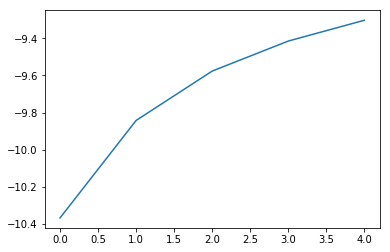

In [61]:
%matplotlib inline
model.plot()

#### Answer here:

### 4. Simulate a new State of the Union speech

Write a function `new_speech` using the `MyGibbs` class to use the estimated values for $\Phi$ from your model (with stop words removed) to simulate a new State of the Union speech. Start out by simulating $\theta_d \sim Dir(\alpha = 0.5)$ and then simulate your document. Does it make sense? Why, why not?

In [103]:
def new_speech(model, alpha, num_words):
    theta = np.random.dirichlet([alpha]*model.num_topics)
    
    speech = []
    
    for i in range(num_words):
        z = np.random.choice(model.num_topics, p=arr1)        
        p = model.term_topics[:,z]/np.sum(model.term_topics[:,z])
        
        index = np.random.choice(model.num_terms, p=p)
        
        speech.append( model.vocab[index] )
        
    return " ".join(speech)

In [104]:
new_speech(model, 0.5, 100)

'international stark debt visited national federal actively stick unity newborn 2 federal east aliens years experienced interests future helping address youth stable administration levels states human settlements symphony system 000 efficient holds communities incomes single actions loans fight incentives imperial critical higher congress choose united investment base breakdown result read american goals promote american united federal sacrifice 1990s choice years margin today secured environment provide people caribbean include persian maintain hope married guarantees soviet wanted full international gnp propose projects percent uncertainty international parents insurance numerous tools inhabitants compromises congress 4 hundred life america passed federal peace include freedom cost'

#### Answer here:
The speech does not make sense. We have no structure included in our model. There is no syntax etc. Currently we just sample common words from topics independently. 

### Bonus assignment:

To get better understanding how to implement the underlying model or similar models, you might want to implement your own function to compute the log marginal posterior. If so, implement the `compute_logprob` function.

$$\begin{align}
\log p(\mathbf{z}|\mathbf{w}) =& \log\prod^{K}p(\mathbf{w}|\mathbf{z},\beta)\prod^{D}p(\mathbf{z}|\alpha) \\
=& \sum^{K}\log\left[\frac{\Gamma\left(\sum^{V}\beta\right)}{\prod^{V}\Gamma\left(\beta\right)}\frac{\prod^{V}\Gamma\left(n_{kv}^{(w)}+\beta\right)}{\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)}\right]+\sum^{D}\log\left[\frac{\Gamma\left(\sum^{K}\alpha\right)}{\prod^{K}\Gamma\left(\alpha\right)}\frac{\prod^{K}\Gamma\left(n_{dk}^{(d)}+\alpha\right)}{\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)}\right] \\
=& K\log\Gamma\left(V\beta\right)-KV\log\Gamma\left(\beta\right)+\sum^{K}\sum^{V}\log\Gamma\left(n_{kv}^{(w)}+\beta\right)-\sum^{K}\log\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)\\
&+ D\log\Gamma\left(K\alpha\right)-DK\log\Gamma\left(\alpha\right)+\sum^{D}\sum^{K}\log\Gamma\left(n_{dk}^{(d)}+\alpha\right)-\sum^{D}\log\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)
\end{align}$$

In Python, use `scipy.special.gammaln` for $\log\Gamma(x)$ (if you run into problems, you might try `math.lgamma` instead).

In [97]:
arr1 = np.random.dirichlet([0.5]*10)
z = np.random.choice(10, p=arr1)

p = model.term_topics[:,z]/np.sum(model.term_topics[:,z])


np.random.choice("num_words", p=p)

1